# 20대 젠더 관련 의안 분석

### 2016.05.30 ~ 2020.05.29 / 이명박 박근혜 정부

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
%matplotlib inline

In [2]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.



In [3]:
bill_df = pd.read_csv('21대 국회 의안정보.csv', parse_dates=['제안일자', '의결일자'])

bill_df = bill_df.drop_duplicates().fillna('')
bill_df.shape

(5923, 10)

In [4]:
def preprocessing(text): 
    text = text.replace('■ 주요내용', ' ').replace('■ 주요골자', ' ').replace('■ 기타사항', ' ').replace('■ 제안경위', ' ')
    text = text.replace('제안이유',' ').replace('주요내용',' ').replace('[',' ').replace(']',' ')
    text = text.replace('참고사항', ' ').replace('■ 위원회 수정이유', ' ').replace('■ 위원회 수정주요내용',' ')
    text = text.replace("'",' ').replace('□ 수정이유',' ').replace('주요골자', ' ').replace('■ 수정사항',' ')
    return text

def clean_name(text): 
    text = text.split('(')[0]
    return text.strip()

In [5]:
%time bill_df['제안이유'] = bill_df['제안이유'].apply(preprocessing)
%time bill_df['의안명'] = bill_df['의안명'].apply(clean_name)

CPU times: user 47.8 ms, sys: 4.71 ms, total: 52.6 ms
Wall time: 56.2 ms
CPU times: user 6.57 ms, sys: 424 µs, total: 6.99 ms
Wall time: 7.8 ms


## 젠더 관련 의안만 추리기

In [6]:
# 여성가족위원회!
bill_df['소관위원회'].unique()

array(['[]', '문화체육관광위원회', '보건복지위원회', '여성가족위원회', '교육위원회', '과학기술정보방송통신위원회',
       '기획재정위원회', '행정안전위원회', '산업통상자원중소벤처기업위원회', '국토교통위원회', '국방위원회',
       '농림축산식품해양수산위원회', '법제사법위원회', '정무위원회', '환경노동위원회', '국회운영위원회',
       '외교통일위원회', '', '정보위원회'], dtype=object)

In [7]:
comm = bill_df[(bill_df['소관위원회'] == '여성가족위원회')]
comm['의안명'].unique()

array(['아동·청소년의 성보호에 관한 법률 일부개정법률안', '청소년 기본법 전부개정법률안',
       '청소년활동 진흥법 일부개정법률안', '청소년 보호법 일부개정법률안', '청소년복지 지원법 일부개정법률안',
       '양성평등기본법 일부개정법률안', '성폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안',
       '데이트폭력등 방지 및 피해자보호 등에 관한 법률안', '건강가정기본법 일부개정법률안',
       '양육비 이행확보 및 지원에 관한 법률 일부개정법률안', '건전가정의례의 정착 및 지원에 관한 법률 폐지법률안',
       '다문화가족지원법 전부개정법률안', '한부모가족지원법 일부개정법률안',
       '학교 밖 청소년 지원에 관한 법률 일부개정법률안', '가정폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안',
       '일제하 일본군위안부 피해자에 대한 보호ㆍ지원 및 기념사업 등에 관한 법률 일부개정법률안',
       '경력단절여성등의 경제활동 촉진법 일부개정법률안', '아이돌봄 지원법 일부개정법률안',
       '일본군위안부 피해 진상규명 및 명예회복에 관한 특별법안'], dtype=object)

In [8]:
keyword = r'.*(포르노|웹하드|몸캠|공중화장실|공중 화장실|몰카|몰래카메라|사이버범죄|카르텔\
                N번방|n번방|불법촬영|디지털성범죄|사이버 범죄|불법 촬영|\
                버닝썬|딥페이크|촬영물).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(38, 10)

In [9]:
for ind in range(0, len(gender)): 
    print(gender.loc[ind,'의안번호'])
    print(gender.loc[ind, '의안명'])
    print(gender.loc[ind, '제안이유'])

2106048
유아교육법 일부개정법률안
  대안의  최근 텔레그램 N번방 사건 등과 같은 디지털성범죄가 계속 발생하며 이에 연루된 유료회원이 100여명이 넘어가고 공익근무요원, 군인 등 다양한 직종의 사람들이 검거되고 있음. 또한 가해자 중 30% 이상이 미성년자로 밝혀져, 재발 방지를 위해서는 성장기에 올바른 교육이 이루어지도록 학생을 가르치는 교사의 자격 취득을 더욱 엄격히 하여 교사의 도덕성을 제고할 필요가 있음.또한, 자격증은 특정 분야의 직무 수행에 필요한 사항에 대한 자격을 검증하여 상호 간 거래의 신뢰를 형성하는 매개가 되며, 국민의 생명, 재산, 권리ㆍ의무 등과 밀접하게 연관되므로, 자격증의 대여ㆍ알선 행위는 엄격하게 제재하여야 함.그런데 개별법에서 규정하고 있는 자격증의 대여ㆍ알선 행위에 대한 제재 여부 또는 제재 수준이 다양하여 형평성에 대한 논란이 제기되고 있고, 지난 해 국민권익위원회에서도 이에 대한 제재 간 형평성을 제고하고 미비한 제재는 강화할 것을 각 중앙행정기관의 장에게 권고한바, 현행법에서 교원 자격증을 빌려주거나 빌리는 행위 또는 이를 알선하는 행위를 금지하고 해당 행위 시 제재 규정을 마련할 필요가 있음.한편, 「국가공무원법」상 국가공무원의 결격사유에 해당하는 사람은 유치원운영위원회의 위원이 될 수 없도록 하고, 유치원운영위원회의 위원이 그 결격사유에 해당하면 당연히 퇴직하도록 함으로써 유치원운영위원회의 기능을 수행하는 데에 자질이 부족한 사람은 해당 유치원운영위원회의 위원으로 활동할 수 없도록 하려는 것임.대안의  가. 「국가공무원법」상 국가공무원의 결격사유에 해당하는 사람은 유치원운영위원회의 위원이 될 수 없도록 하고, 유치원운영위원회의 위원이 그 결격사유에 해당하면 당연히 퇴직하도록 함(안 제19조의3제3항 및 제4항 신설).나. 대마ㆍ마약ㆍ향정신성의약품 중독자 또는 성범죄 행위로 인해 형 또는 치료감호가 확정된 사람은 교사의 자격을 취득할 수 없도록 함(안 제22조의2 신설).다. 「형법」 제38조에도 불구하고 제22조

In [32]:
remove_bill = [2024972, 2024962, 2024920, 2024913, 2024912, 2024910, 2024893, 2024834, 2024805, 2024798, 2024783, 
               2024760, 2024700, 2024684, 2024679, 2024669, 2024651, 2024649, 2024576, 2024521, 2024492, 2024482, 
               2024478, 2024353, 2024339, 2024338, 2024332, 2024219, 2024181, 2024179, 2024132, 2024113, 2024091, 
               2024090, 2024076, 2024051, 2024033, 2024031, 2023997, 2023981, 2023964, 2023962, 2023937, 2023914, 
               2023902, 2023901, 2023873, 2023838, 2023836, 2023819, 2023759, 2023747, 2023733, 2023718, 2023687, 
               2023621, 2023616, 2023605, 2023511, 2023456, 2023448, 2023446, 2023415, 2023379, 2023353, 2023343, 
               2023331, 2023330, 2023283, 2023260, 2023215, 2023189, 2023157, 2023114, 2023085, 2023070, 2023060, 
               2023059, 2023038, 2023013, 2022978, 2022960, 2022944, 2022932, 2022811, 2022804, 2022796, 2022784, 
               2022771, 2022744, 2022734, 2022728, 2022723, 2022717, 2022677, 2022653, 2022635, 2022617, 2022592, 
               2022547, 2022544, 2022536, 2022510, 2022426, 2022418, 2022396, 2022394, 2022379, 2022378, 2022362, 
               2022326, 2022311, 2022281, 2022265, 2022242, 2022234, 2022215, 2022184, 2022135, 2022125, 2022100, 
               2022061, 2022060, 2022046, 2021983, 2021981, 2021979, 2021936, 2021912, 2021883, 2021867, 2021859, 
               2021843, 2021832, 2021814, 2021779, 2021698, 2021690, 2021666, 2021662, 2021661, 2021646, 2021631, 
               2021620, 2021596, 2021577, 2021560, 2021540, 2021473, 2021468, 2021445, 2021396, 2021395, 2021392, 
               2021342, 2021340, 2021336, 2021312, 2021296, 2021268, 2021242, 2021239, 2021221, 2021179, 2021174, 
               2021173, 2021164, 2021125, 2021121, 2021092, 2021089, 2021085, 2021044, 2021020, 2021005, 2020925, 
               2020957, 2020956, 2020918, 2020884, 2020817, 2020785, 2020783, 2020767, 2020746, 2020727, 2020656, 
               2020624, 2020606, 2020594, 2020593, 2020571, 2020540, 2020539, 2020535, 2020516, 2020515, 2020490, 
               2020474, 2020415, 2020393, 2020316, 2020274, 2020263, 2020256, 2020243, 2020232, 2020216, 2020178, 
               2020177, 2020142, 2020118, 2020110, 2020095, 2020081, 2020066, 2020062, 2020039, 2020006, 2019982, 
               2019958, 2019938, 2019916, 2019909, 2019895, 2019868, 2019850, 2019839, 2019826, 2019825, 2019819, 
               2019811, 2019796, 2019757, 2019754, 2019738, 2019737, 2019726, 2019724, 2019716, 2019700, 2019699, 
               2019695, 2019694, 2019693, 2019692, 2019690, 2019688, 2019687, 2019685, 2019649, 2019633, 2019629, 
               2019584, 2019555, 2019528, 2019504, 2019498, 2019473, 2019431, 2019416, 2019386, 2019380, 2019378, 
               2019377, 2019336, 2019325, 2019272, 2019154, 2019147, 2019130, 2019125, 2019114, 2019063, 2019062, 
               2019060, 2019036, 2019024, 2019013, 2019005, 2018978, 2018972, 2018958, 2018948, 2018944, 2018932, 
               2018930, 2018884, 2018877, 2018866, 2018836, 2018828, 2018824, 2018763, 2018756, 2018698, 2018695, 
               2018682, 2018676, 2018660, 2018626, 2018620, 2018583, 2018505, 2018494, 2018480, 2018472, 2018468,
               2018435, 2018434, 2018396, 2018394, 2018376, 2018288, 2018283, 2018250, 2018157, 2018148, 2018132, 
               2018125, 2018085, 2018068, 2018065, 2018063, 2018037, 2018017, 2018014, 2017914, 2017912, 2017904, 
               2017892, 2017874, 2017868, 2017851, 2017795, 2017791, 2017783, 2017781, 2017771, 2017739, 2017722, 
               2017704, 2017695, 2017661, 2017659, 2017657, 2017648, 2017634, 2017602, 2017589, 2017579, 2017571, 
               2017533, 2017525, 2017488, 2017412, 2017326, 2017322, 2017321, 2017319, 2017288, 2017190, 2017189, 
               2017187, 2017186, 2017164, 2017136, 2017047, 2017045, 2017044, 2017034, 2017018, 2017008, 2016976, 
               2016964, 2016910, 2016907, 2016896, 2016893, 2016880, 2016870, 2016823, 2016815, 2016814, 2016811, 
               2016788, 2016724, 2016683, 2016671, 2016636, 2016632, 2016626, 2016625, 2016624, 2016607, 2016597, 
               2016579, 2016560, 2016559, 2016557, 2016547, 2016528, 2016521, 2016486, 2016471, 2016464, 2016457, 
               2016449, 2016416, 2016390, 2016373, 2016364, 2016345, 2016342, 2016308, 2016281, 2016258, 2016247, 
               2016236, 2016196, 2016148, 2016093, 2016070, 2016055, 2016009, 2015984, 2015972, 2015953, 2015912, 
               2015900, 2015898, 2015897, 2015893, 2015879, 2015839, 2015834, 2015820, 2015818, 2015813, 2015773, 
               2015762, 2015757, 2015749, 2015738, 2015718, 2015683, 2015629, 2015559, 2015512, 2015511, 2015509, 
               2015508, 2015507, 2015505, 2015504, 2015503, 2015501, 2015499, 2015498, 2015496, 2015488, 2015458, 
               2015449, 2015424, 2015369, 2015364, 2015361, 2015348, 2015347, 2015334, 2015327, 2015297, 2015236,
               2015235, 2015205, 2015195, 2015178, 2015173, 2015146, 2015099, 2015093, 2015094, 2015070, 2015049, 
               2015045, 2015035, 2015001, 2014974, 2014968, 2014967, 2014966, 2014950, 2014887, 2014871, 2014830, 
               2014800, 2014768, 2014753, 2014744, 2014679, 2014638, 2014629, 2014620, 2014619, 2014571, 2014549, 
               2014539, 2014521, 2014505, 2014492, 2014455, 2014426, 2014425, 2014371, 2014358, 2014355, 2014343, 
               2014306, 2014305, 2014299, 2014294, 2014247, 2014211, 2014201, 2014195, 2014153, 2014105, 2014073, 
               2014059, 2013994, 2013992, 2013985, 2013941, 2013861, 2013849, 2013832, 2013831, 2013829, 2013828, 
               2013802, 2013763, 2013665, 2013638, 2013584, 2013572, 2013561, 2013542, 2013532, 2013525, 2013519, 
               2013464, 2013443, 2013441, 2013434, 2013419, 2013418, 2013407, 2013357, 2013346, 2013333, 2013331, 
               2013262, 2013257, 2013250, 2013221, 2013169, 2013134, 2013120, 2013094, 2013079, 2013065, 2013063, 
               2013060, 2013059, 2013050, 2013044, 2012990, 2012987, 2012951, 2012927, 2012909, 2012906, 2012902, 
               2012864, 2012857, 2012850, 2012774, 2012718, 2012681, 2012637, 2012633, 2012621, 2012589, 2012457,
               2012445, 2012383, 2012338, 2012303, 2012294, 2012262, 2012261, 2012192, 2012152, 2012133, 2012123, 
               2012118, 2012105, 2012093, 2012063, 2011990, 2011869, 2011849, 2011765, 2011745, 2011743, 2011741, 
               2011740, 2011735, 2011727, 2011718, 2011606, 2011605, 2011573, 2011502, 2011453, 2011425, 2011386, 
               2011373, 2011368, 2011353, 2011340, 2011306, 2011264, 2011254, 2011197, 2011159, 2011080, 2011053, 
               2011053, 2011025, 2010984, 2010953, 2010944, 2010916, 2010899, 2010889, 2010841, 2010818, 2010815,
               2010814, 2010813, 2010803, 2010799, 2010792, 2010731, 2010677, 2010667, 2010645, 2010636, 2010603, 
               2010600, 2010596, 2010566, 2010565, 2010557, 2010556, 2010538, 2010470, 2010459, 2010455, 2010452, 
               2010434, 2010405, 2010401, 2010400, 2010383, 2010381, 2010365, 2010271, 2010255, 2010253, 2010241, 
               2010232, 2010209, 2010190, 2010183, 2010177, 2010157, 2010142, 2010102, 2010100, 2010081, 2010033, 
               2010013, 2009995, 2009986, 2009943, 2009941, 2009914, 2009898, 2009810, 2009802, 2009775, 2009757, 
               2009751, 2009750, 2009745, 2009700, 2009695, 2009684, 2009682, 2009680, 2009676, 2009674, 2009670, 
               2009581, 2009558, 2009556, 2009555, 2009538, 2009537, 2009502, 2009496, 2009461, 2009460, 2009454, 
               2009440, 2009399, 2009396, 2009353, 2009352, 2009351, 2009324, 2009323, 2009305, 2009233, 2009215, 
               2009210, 2009181, 2009156, 2009144, 2009122, 2009111, 2009110, 2009059, 2009042, 2009004, 2008997, 
               2008989, 2008964, 2008951, 2008948, 2008891, 2008869, 2008847, 2008841, 2008831, 2008783, 2008748, 
               2008734, 2008731, 2008684, 2008649, 2008635, 2008625, 2008602, 2008599, 2008585, 2008536, 2008532, 
               2008527, 2008526, 2008508, 2008505, 2008484, 2008468, 2008460, 2008447, 2008444, 2008440, 2008435, 
               2008421, 2008388, 2008349, 2008343, 2008287, 2008260, 2008131, 2008128, 2008124, 2008073, 2008065, 
               2008031, 2008021, 2007995, 2007987, 2007957, 2007937, 2007928, 2007924, 2007903, 2007883, 2007844, 
               2007828, 2007796, 2007722, 2007717, 2007713, 2007704, 2007690, 2007676, 2007670, 2007664, 2007641, 
               2007630, 2007586, 2007520, 2007449, 2007442, 2007440, 2007439, 2007415, 2007355, 2007349, 2007343, 
               2007339, 2007331, 2007326, 2007300, 2007287, 2007247, 2007228, 2007208, 2007198, 2007146, 2007145,
               2007092, 2007091, 2007048, 2007039, 2007028, 2006972, 2006971, 2006952, 2006925, 2006914, 
               2006886, 2006885, 2006884, 2006883, 2006881, 2006878, 2006877, 2006799, 2006785, 2006783, 2006782,
               2006781, 2006777, 2006759, 2006756, 2006753, 2006751, 2006685, 2006664, 2006638, 2006627, 
               2006622, 2006620, 2006610, 2006607, 2006601, 2006586, 2006585, 2006561, 2006537, 2006532, 2006521, 
               2006519, 2006502, 2006500, 2006454, 2006449, 2006443, 2006429, 2006410, 2006367, 2006325, 2006306, 
               2006239, 2006238, 2006209, 2006186, 2006181, 2006153, 2006121, 2006117, 2006075, 2006002, 2005983, 
               2005961, 2005956, 2005926, 2005873, 2005851, 2005833, 2005817, 2005799, 2005728, 2005704, 2005639, 
               2005638, 2005590, 2005578, 2005575, 2005557, 2005501, 2005453, 2005435, 2005420, 2005418, 2005379, 
               2005375, 2005361, 2005352, 2005343, 2005280, 2005272, 2005271, 2005225, 2005210, 2005202, 2005186, 
               2005165, 2005116, 2005007, 2004999, 2004985, 2004977, 2004972, 2004896, 2004859, 2004849, 2004799, 
               2004792, 2004788, 2004777, 2004741, 2004698, 2004645, 2004529, 2004521, 2004501, 2004484, 2004479, 
               2004412, 2004403, 2004397, 2004389, 2004378, 2004344, 2004342, 2004337, 2004336, 2004323, 2004314, 
               2004298, 2004276, 2004276, 2004261, 2004259, 2004221, 2004204, 2004193, 2004185, 2004160, 2004156, 
               2004135, 2004131, 2004123, 2004122, 2004120, 2004115, 2004108, 2004086, 2004076, 2004058, 2004024, 
               2004020, 2004002, 2003996, 2003995, 2003989, 2003987, 2003930, 2003921, 2003872, 2003847, 2003840, 
               2003836, 2003817, 2003816, 2003809, 2003767, 2003759, 2003747, 2003661, 2003651, 2003645, 2003625, 
               2003614, 2003582, 2003546, 2003533, 2003496, 2003472, 2003455, 2003454, 2003451, 2003394, 2003353, 
               2003346, 2003337, 2003334, 2003327, 2003291, 2003229, 2003216, 2003191, 2003137, 2003134, 2003132, 
               2003131, 2003123, 2003064, 2003051, 2003048, 2003047, 2003041, 2003040, 2003039, 2003025, 2003023, 
               2002981, 2002927, 2002887, 2002854, 2002848, 2002842, 2002824, 2002823, 2002779, 2002766, 2002718, 
               2002649, 2002639, 2002636, 2002581, 2002580, 2002579, 2002566, 2002562, 2002555, 2002553, 2002532, 
               2002521, 2002516, 2002508, 2002499, 2002497, 2002496, 2002474, 2002471, 2002447, 2002439, 2002437, 
               2002433, 2002398, 2002359, 2002306, 2002290, 2002286, 2002256, 2002248, 2002224, 2002220, 2002212, 
               2002206, 2002203, 2002185, 2002172, 2002159, 2002152, 2002150, 2002139, 2002129, 2002107, 2002106, 
               2002097, 2002088, 2002085, 2002071, 2002065, 2002010, 2001992, 2001984, 2001975, 2001958, 2001955, 
               2001948, 2001947, 2001913, 2001893, 2001884, 2001845, 2001841, 2001836, 2001778, 2001774, 2001742, 
               2001729, 2001709, 2001691, 2001665, 2001630, 2001603, 2001589, 2001545, 2001502, 2001454, 2001451,
               2001447, 2001410, 2001404, 2001403, 2001327, 2001311, 2001217, 2001206, 2001161, 2001142, 2001120, 
               2001050, 2001006, 2000995, 2000862, 2000821, 2000808, 2000802, 2000785, 2000758, 2000754, 2000746, 
               2000711, 2000694, 2000708, 2000688, 2000687, 2000684, 2000676, 2000672, 2000664, 2000631, 2000629, 
               2000626, 2000569, 2000568, 2000561, 2000548, 2000534, 2000498, 2000481, 2000462, 2000449, 2000445, 
               2000437, 2000436, 2000405, 2000402, 2000370, 2000348, 2000335, 2000324, 2000322, 2000311, 2000310, 
               2000286, 2000284, 2000277, 2000261, 2000189, 2000184, 2000181, 2000173, 2000162, 2000138, 2000137, 
               2000130, 2000128, 2000127, 2000097, 2000085, 2000072, 2000066, 2000050, 2000049, 2000046, 2000043, 
               2000033, 2000025, 2000015, 2000013, 2000012, 2000004, 2000003, 2024869, 2010474, 2005202, 2003291, 
               2003229, 2001955, 2000694, 2000286, 2000277, 2000181, 2000128, 2000046
               ]
glass_list = [2017482, 2017481, 2017480, 2017479, 2017478, 2017477,
       2017476, 2017475, 2017474, 2017473, 2017472, 2017470, 2017469,
       2017468, 2017467, 2017465, 2017464, 2017463, 2017462, 2017461,
       2017460, 2017459, 2017458, 2017457, 2017455, 2017454, 2017453,
       2017451, 2017450, 2017449, 2017448, 2017447, 2017446, 2017445,
       2017444, 2017443, 2017441, 2017440, 2017439, 2017438, 2017437,
       2017436, 2017434, 2017433, 2017432, 2017431, 2017430, 2017429,
       2017428, 2017427, 2017426, 2017425, 2017424, 2017423, 2017422,
       2017421, 2017420, 2017419, 2017417, 2017416, 2017415, 2017413,
       2017411, 2017409, 2017407, 2017406, 2017405, 2017404, 2017403,
       2017402, 2017401, 2017400, 2017399, 2017398, 2017397, 2017396,
       2017395, 2017394, 2017392, 2017391, 2017390, 2017389, 2017388,
       2017387, 2017386, 2017385, 2017384, 2017383, 2017382, 2017381,
       2017380, 2017379, 2017377, 2017376, 2017375, 2017374, 2017373,
       2017372, 2017371, 2017370, 2017369, 2017368, 2017367, 2017366,
       2017365, 2017364, 2017363, 2017362, 2017361, 2017360, 2017359,
       2017358, 2017357, 2017356, 2017355, 2017354, 2017353, 2017352,
       2017351, 2017350, 2017349, 2017348, 2017347, 2017346, 2017345,
       2017344, 2017343, 2017342, 2017341, 2017340, 2017339, 2017338,
       2017337, 2017336, 2017335, 2017334, 2017333, 2017332, 2017284,
       2017283, 2017282, 2017281, 2017280, 2017279, 2017278, 2017277,
       2017276, 2017275, 2017274, 2017273, 2017272, 2017271, 2017270,
       2017269, 2017268, 2017267, 2017266, 2017265, 2017264, 2017263,
       2017262, 2017261, 2017260, 2017259, 2017258, 2017257, 2017256,
       2017255, 2017254, 2017253, 2017252, 2017251, 2017250, 2017249,
       2017248, 2017247, 2017246, 2017245, 2017244, 2017243, 2017242,
       2017241, 2017240, 2017239, 2017238, 2017237, 2017236, 2017235,
       2017234, 2017233, 2017232, 2017231, 2017230, 2017229, 2017228,
       2017227, 2017226, 2017225, 2017224, 2017223, 2017222, 2017221,
       2017220, 2017219, 2017218, 2017217, 2017216, 2017215, 2017214,
       2017213, 2017212, 2017211, 2017210, 2017108, 2017106, 2017105,
       2017104, 2017103, 2017089, 2017086, 2017084, 2017083, 2017082,
       2017081, 2017080, 2017078]

In [33]:
gender = gender[~gender['의안번호'].isin(remove_bill)]
gender = gender[~gender['의안번호'].isin(glass_list)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(1789, 14)

In [35]:
gender.to_csv('20th-gender-bill-wo-glass.csv',encoding='utf-8-sig')

## wordcloud 시각화

In [55]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [56]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [57]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 118 ms, sys: 4.64 ms, total: 122 ms
Wall time: 130 ms


In [58]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [59]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 1min 12s, sys: 1.09 s, total: 1min 13s
Wall time: 1min 6s


0    [일제하, 일본군위안부, 피해자, 보호, 지원, 기념사업, 법률, 일부개정법률안, ...
1    [양육비, 이행확보, 지원, 법률, 일부개정법률안, 대안, 한시적, 양육비, 긴급지...
2    [아동, 청소년, 성보호, 법률, 일부개정법률안, 대안, 아동, 청소년, 음란물, ...
Name: tokens, dtype: object

In [60]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 980 ms, sys: 12.3 ms, total: 992 ms
Wall time: 708 ms


In [61]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [62]:
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-26 14:28:37,912 : INFO : collecting all words and their counts
2020-09-26 14:28:37,914 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-26 14:28:37,953 : INFO : collected 13167 word types from a corpus of 164902 raw words and 2016 sentences
2020-09-26 14:28:37,954 : INFO : Loading a fresh vocabulary
2020-09-26 14:28:38,233 : INFO : effective_min_count=10 retains 2107 unique words (16% of original 13167, drops 11060)
2020-09-26 14:28:38,234 : INFO : effective_min_count=10 leaves 139254 word corpus (84% of original 164902, drops 25648)
2020-09-26 14:28:38,246 : INFO : deleting the raw counts dictionary of 13167 items
2020-09-26 14:28:38,248 : INFO : sample=0.001 downsamples 69 most-common words
2020-09-26 14:28:38,249 : INFO : downsampling leaves estimated 121186 word corpus (87.0% of prior 139254)
2020-09-26 14:28:38,256 : INFO : estimated required memory for 2107 words and 100 dimensions: 2739100 bytes
2020-09-26 14:28:38,257 : INFO : resetting

2020-09-26 14:28:40,635 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 14:28:40,636 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 14:28:40,637 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 14:28:40,638 : INFO : EPOCH - 15 : training on 164902 raw words (121248 effective words) took 0.1s, 1000949 effective words/s
2020-09-26 14:28:40,747 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 14:28:40,753 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 14:28:40,755 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 14:28:40,758 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 14:28:40,759 : INFO : EPOCH - 16 : training on 164902 raw words (121278 effective words) took 0.1s, 1101266 effective words/s
2020-09-26 14:28:40,868 : INFO : worker thread finished; awaiting finish of 3 more thread

2020-09-26 14:28:42,707 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 14:28:42,707 : INFO : EPOCH - 31 : training on 164902 raw words (121161 effective words) took 0.1s, 1118884 effective words/s
2020-09-26 14:28:42,809 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 14:28:42,813 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 14:28:42,817 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 14:28:42,818 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 14:28:42,818 : INFO : EPOCH - 32 : training on 164902 raw words (121311 effective words) took 0.1s, 1127843 effective words/s
2020-09-26 14:28:42,932 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 14:28:42,942 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 14:28:42,943 : INFO : worker thread finished; awaiting finish of 1 more thread

2020-09-26 14:28:44,675 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 14:28:44,683 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 14:28:44,691 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 14:28:44,692 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 14:28:44,693 : INFO : EPOCH - 48 : training on 164902 raw words (121165 effective words) took 0.1s, 1100122 effective words/s
2020-09-26 14:28:44,792 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 14:28:44,797 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 14:28:44,800 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 14:28:44,801 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 14:28:44,802 : INFO : EPOCH - 49 : training on 164902 raw words (121225 effective words) took 0.1s, 1161440 effective words/

2020-09-26 14:28:46,553 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 14:28:46,563 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 14:28:46,564 : INFO : EPOCH - 64 : training on 164902 raw words (121123 effective words) took 0.1s, 1051159 effective words/s
2020-09-26 14:28:46,659 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 14:28:46,665 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 14:28:46,666 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 14:28:46,667 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 14:28:46,668 : INFO : EPOCH - 65 : training on 164902 raw words (121072 effective words) took 0.1s, 1278045 effective words/s
2020-09-26 14:28:46,767 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 14:28:46,776 : INFO : worker thread finished; awaiting finish of 2 more thread

2020-09-26 14:28:48,430 : INFO : EPOCH - 80 : training on 164902 raw words (121154 effective words) took 0.1s, 1127729 effective words/s
2020-09-26 14:28:48,529 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 14:28:48,533 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 14:28:48,537 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 14:28:48,539 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 14:28:48,541 : INFO : EPOCH - 81 : training on 164902 raw words (121310 effective words) took 0.1s, 1155472 effective words/s
2020-09-26 14:28:48,653 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 14:28:48,654 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 14:28:48,657 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 14:28:48,661 : INFO : worker thread finished; awaiting finish of 0 more thread

2020-09-26 14:28:50,407 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 14:28:50,410 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 14:28:50,412 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 14:28:50,413 : INFO : EPOCH - 97 : training on 164902 raw words (121209 effective words) took 0.1s, 1131332 effective words/s
2020-09-26 14:28:50,531 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 14:28:50,534 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 14:28:50,536 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 14:28:50,538 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 14:28:50,540 : INFO : EPOCH - 98 : training on 164902 raw words (120960 effective words) took 0.1s, 1025740 effective words/s
2020-09-26 14:28:50,651 : INFO : worker thread finished; awaiting finish of 3 more thread

In [63]:
print(model.wv.most_similar('여성'))
print(model.wv.most_similar('청소년'))

2020-09-26 14:28:50,790 : INFO : precomputing L2-norms of word weight vectors


[('유리천장', 0.3961271643638611), ('공공기관', 0.3934946656227112), ('인사상', 0.3861405849456787), ('비율', 0.3753221929073334), ('격차', 0.3699306547641754), ('승진', 0.36667633056640625), ('처우', 0.35142210125923157), ('임금격차', 0.3465948700904846), ('육아', 0.33827733993530273), ('현상', 0.3274492621421814)]
[('아동', 0.5707788467407227), ('청소년대상', 0.4290541708469391), ('청소년성착취물', 0.3732908368110657), ('청소년들', 0.37155449390411377), ('착취', 0.3651643991470337), ('취업제한', 0.3479992747306824), ('장애', 0.34714555740356445), ('음란물', 0.33236774802207947), ('성범죄', 0.3279174864292145), ('배포', 0.32376375794410706)]


In [64]:
gender['tokens']

0       [일제하, 일본군위안부, 피해자, 보호, 지원, 기념사업, 법률, 일부개정법률안, ...
1       [양육비, 이행확보, 지원, 법률, 일부개정법률안, 대안, 한시적, 양육비, 긴급지...
2       [아동, 청소년, 성보호, 법률, 일부개정법률안, 대안, 아동, 청소년, 음란물, ...
3       [가족친화, 사회환경, 조성, 촉진, 법률, 일부개정법률안, 대안, 가족친화, 사회...
4       [가정폭력방지, 피해자보호, 법률, 일부개정법률안, 대안, 배우자, 대한민국, 국민...
                              ...                        
2011    [성폭력범죄, 처벌, 특례법, 일부개정법률안, 술집, 화장실, 여성, 용변, 장면,...
2012    [중등교육법, 일부개정법률안, 심각, 사회문제, 저출산, 원인, 교육비, 금전적, ...
2013    [고등교육법, 일부개정법률안, 현행법, 대학, 등록금, 책정, 내용, 규정하, 등록...
2014    [민법, 일부개정법률안, 현행법, 혼인관계, 종료, 출생, 포태한, 추정, 규정하,...
2015    [교육기본법, 일부개정법률안, 현행법, 국가, 지방자치단체, 경제적, 이유, 교육,...
Name: tokens, Length: 2016, dtype: object

In [65]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [66]:
gender_word = total_tokens(gender['tokens'])

In [67]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','규정함','본회','수립','항제', '의결제','촉진','의결',
            '영역','도모','확대','구현','이외','원안폐','조등']
gender_word = [each_word for each_word in gender_word if each_word not in stopwords]

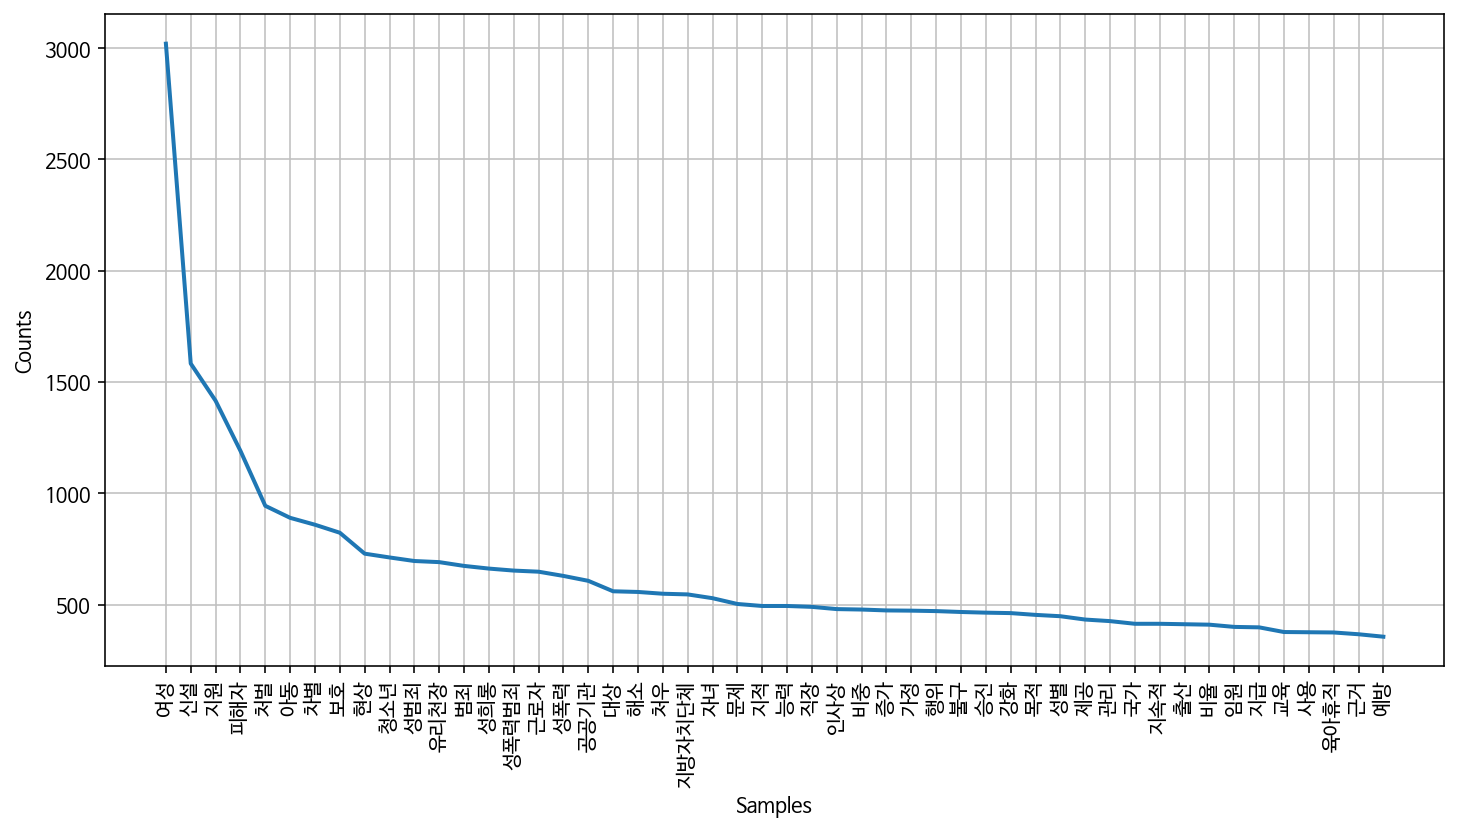

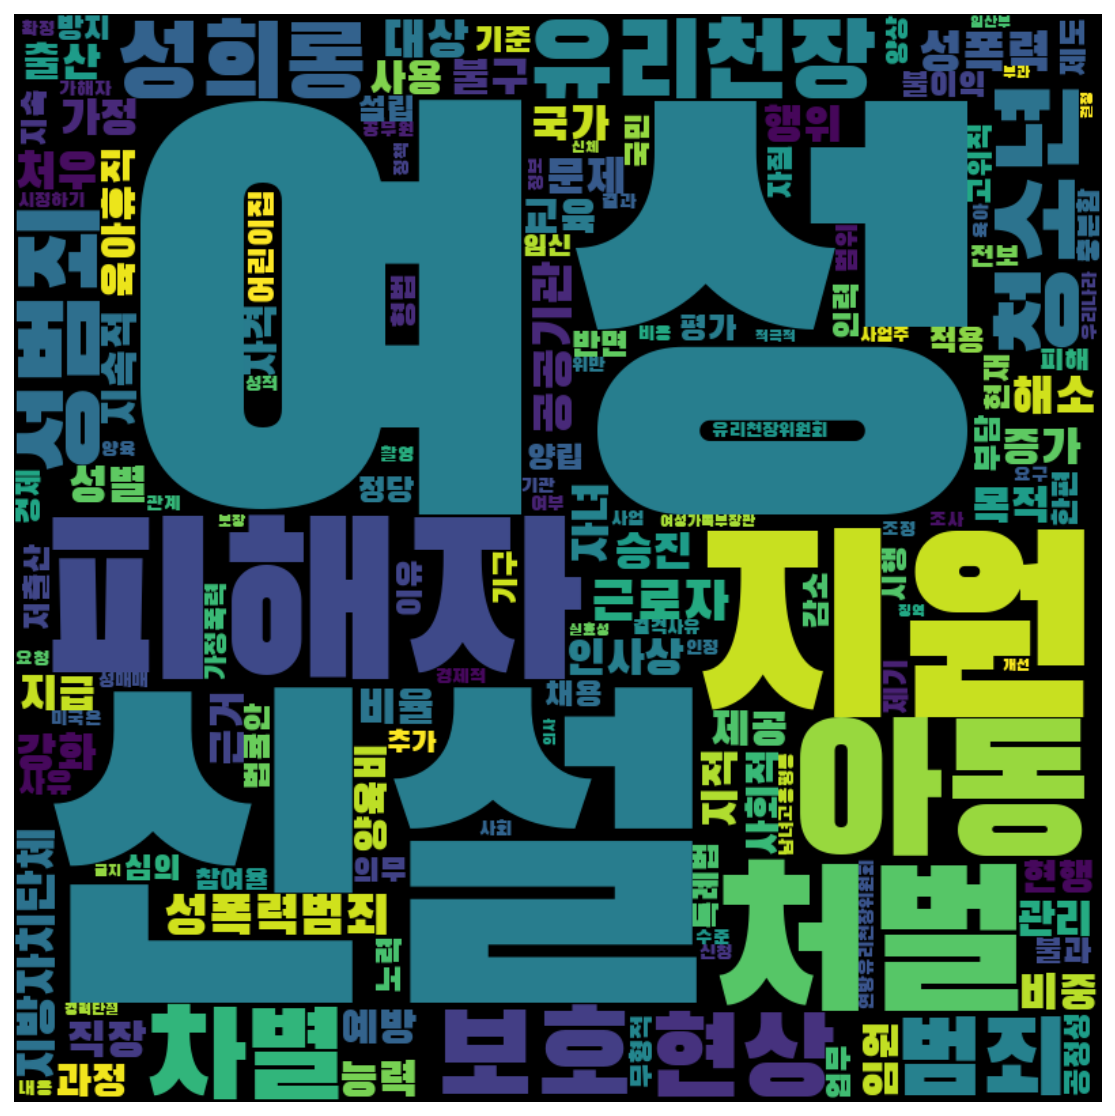

In [68]:
frewords_vis(gender_word)
wordcloud_vis(gender_word)